In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D://Data-Mining//potato-desease//training//PaprikaDataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Paprika_Bakteri', 'Paprika_Sehat']

In [5]:
len(dataset)

78

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1]


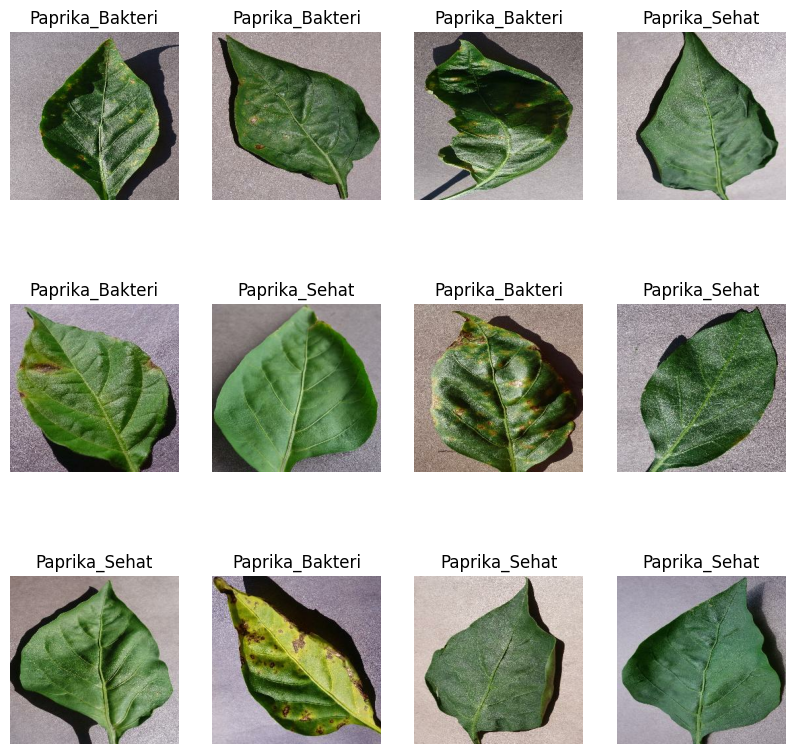

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
train_size = 0.8
len(dataset)*train_size

62.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

24

In [11]:
val_size=0.1
len(dataset)*val_size

7.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

18

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

62

In [17]:
len(val_ds)

7

In [18]:
len(test_ds)

9

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


62/62 [==============================] - 50s 692ms/step - loss: 0.6886 - accuracy: 0.6042 - val_loss: 0.6240 - val_accuracy: 0.6518
Epoch 2/50
62/62 [==============================] - 42s 676ms/step - loss: 0.4269 - accuracy: 0.8217 - val_loss: 0.4353 - val_accuracy: 0.8616
Epoch 3/50
62/62 [==============================] - 42s 669ms/step - loss: 0.2115 - accuracy: 0.9246 - val_loss: 0.2879 - val_accuracy: 0.9554
Epoch 4/50
62/62 [==============================] - 42s 682ms/step - loss: 0.1510 - accuracy: 0.9480 - val_loss: 0.2241 - val_accuracy: 0.9732
Epoch 5/50
62/62 [==============================] - 43s 683ms/step - loss: 0.0703 - accuracy: 0.9837 - val_loss: 0.2473 - val_accuracy: 0.9821
Epoch 6/50
62/62 [==============================] - 43s 683ms/step - loss: 0.0549 - accuracy: 0.9908 - val_loss: 0.1269 - val_accuracy: 0.9955
Epoch 7/50
62/62 [==============================] - 43s 696ms/step - loss: 0.0605 - accuracy: 0.9837 - val_loss: 0.1285 - val_accuracy: 0.97

In [27]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 3s 170ms/step - loss: 0.0061 - accuracy: 1.0000


In [28]:
scores

[0.006131555885076523, 1.0]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 62}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history.history['accuracy']

[0.6041772961616516,
 0.8217014670372009,
 0.9246051907539368,
 0.9480386972427368,
 0.9836984276771545,
 0.9908303618431091,
 0.9836984276771545,
 0.9877738356590271,
 0.9933775067329407,
 0.9928680658340454,
 0.9938868880271912,
 0.9887926578521729,
 0.9928680658340454,
 0.9857361316680908,
 0.9949057698249817,
 0.9877738356590271,
 0.9908303618431091,
 0.9949057698249817,
 0.9928680658340454,
 0.9908303618431091,
 0.9964340329170227,
 0.9821701645851135,
 0.9949057698249817,
 0.996943473815918,
 0.9959245920181274,
 0.9974528551101685,
 0.996943473815918,
 0.9933775067329407,
 0.996943473815918,
 0.9989811778068542,
 0.9933775067329407,
 0.9979622960090637,
 0.998471736907959,
 0.9979622960090637,
 0.9979622960090637,
 0.9933775067329407,
 0.9943963289260864,
 0.996943473815918,
 0.9974528551101685,
 0.996943473815918,
 0.9964340329170227,
 0.9994905591011047,
 0.9979622960090637,
 0.996943473815918,
 0.9989811778068542,
 0.9903209209442139,
 0.9913398027420044,
 0.9974528551101685,

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

50

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6886077523231506,
 0.4269079864025116,
 0.21151454746723175,
 0.15097078680992126,
 0.07029971480369568]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

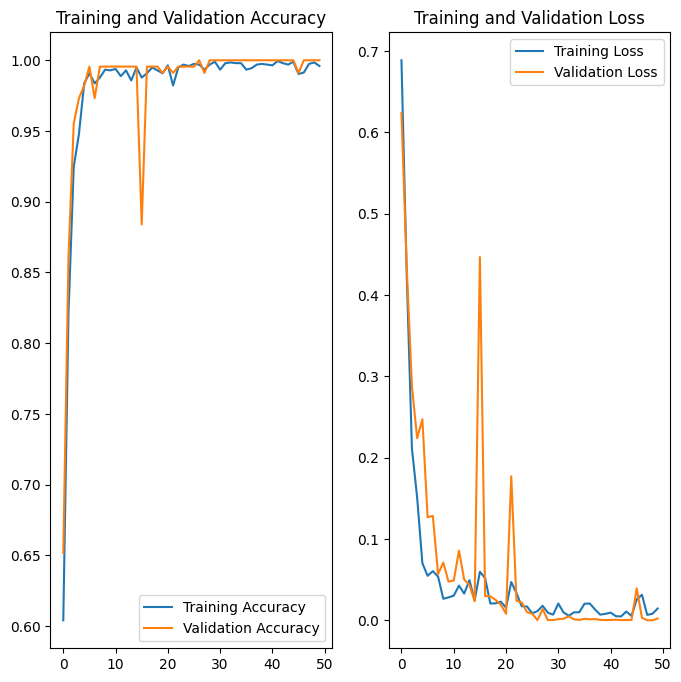

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Paprika_Sehat
1/1 [==============================] - 0s 469ms/step
predicted label: Paprika_Sehat


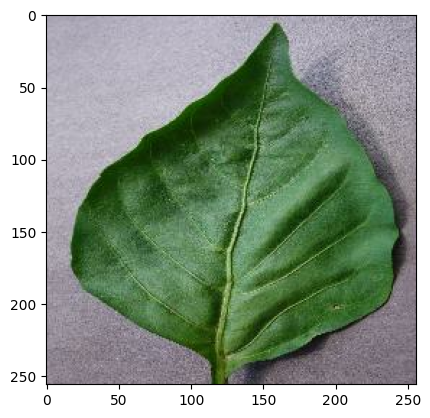

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


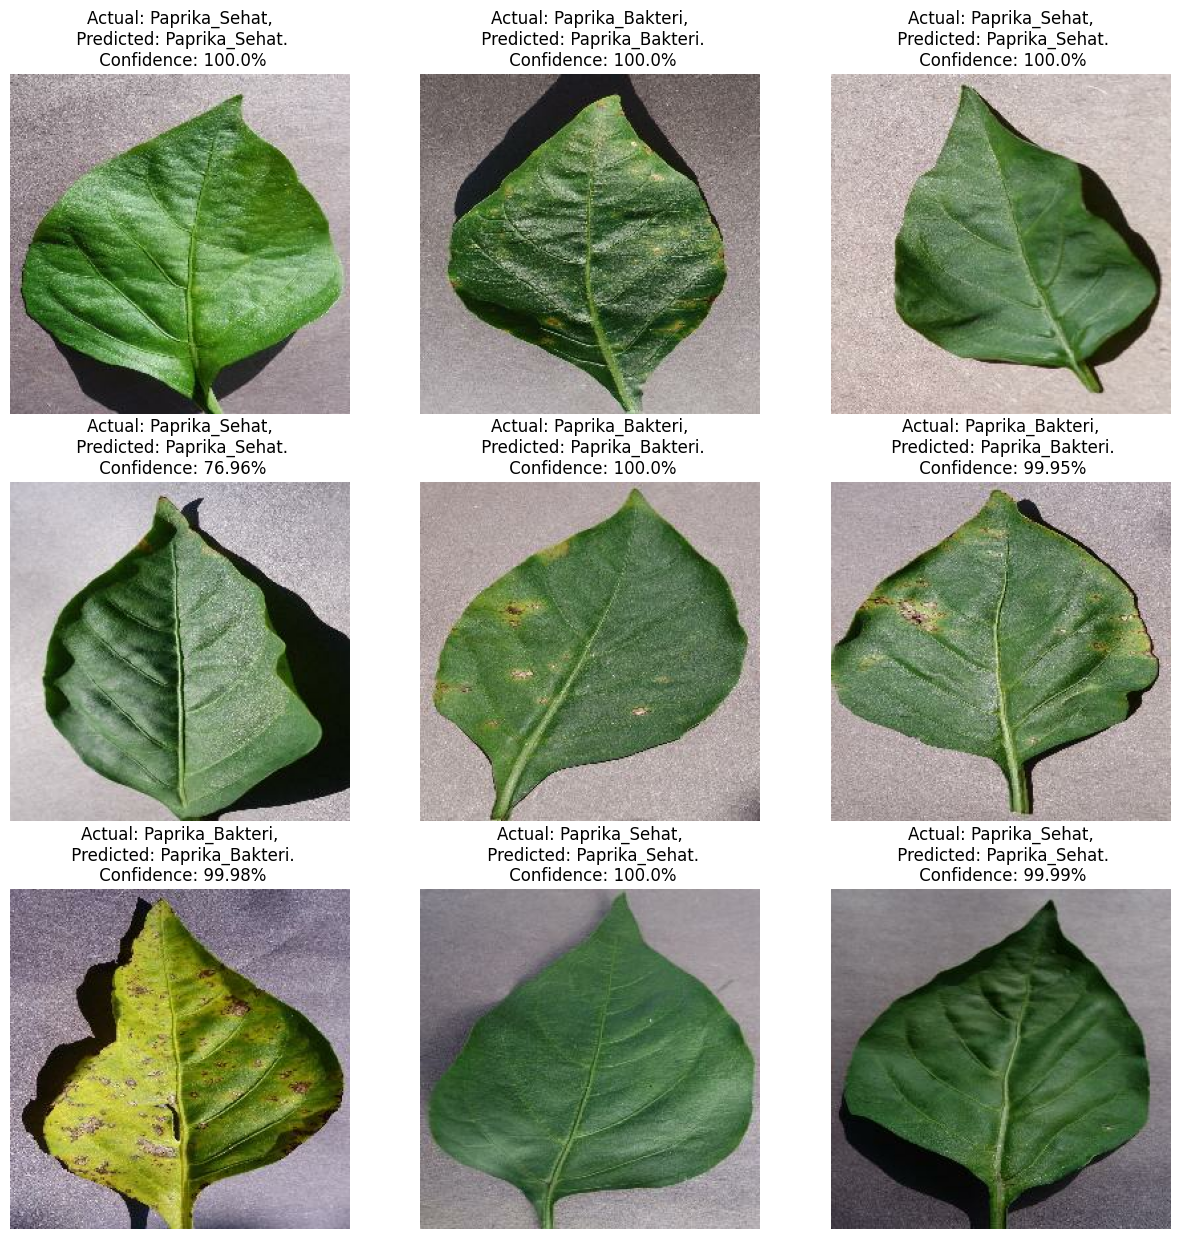

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [46]:
import os
model_version=max([int(i) for i in os.listdir("D:\\React Nativ\\AntaresApps\\Backend\\models") + [0]])+1
model.save(f"D:\\React Nativ\\AntaresApps\\backend\\models/{model_version}")

INFO:tensorflow:Assets written to: D:\React Nativ\AntaresApps\backend\models/1\assets


INFO:tensorflow:Assets written to: D:\React Nativ\AntaresApps\backend\models/1\assets


In [ ]:
model.save("D:\\Data-Mining\\potato-desease\\training\\paprika.h5")